In [1]:
%matplotlib inline

In [2]:
# First run the following in the Google Earth Engine to obtain the data:

# // ----------------------------
# // 1. Define Iceland Geometry
# // ----------------------------
# var iceland = ee.Geometry.Rectangle([-25, 63, -12, 67]);

# // ----------------------------
# // 2. Load ERA5-Land Collection
# // ----------------------------
# var era5 = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR');

# // ----------------------------
# // 3. Define Water Year Range
# // ----------------------------
# var startYear = 1950;
# var endYear = 2023;  // last full water year is 2023–2024
# var waterYears = ee.List.sequence(startYear, endYear);

# // ----------------------------
# // 4. Variables by Aggregation Type
# // ----------------------------
# // Temperature is averaged
# var meanVars = ['temperature_2m'];

# // Precip and snowfall are summed
# var sumVars = ['total_precipitation_sum', 'snowfall_sum'];

# // Combined list for filtering
# var allVars = ee.List(meanVars).cat(sumVars);

# // ----------------------------
# // 5. Compute Water-Year Stats
# // ----------------------------
# var getWaterYearStats = function(year) {
#   year = ee.Number(year);
#   var start = ee.Date.fromYMD(year, 10, 1);
#   var end = start.advance(1, 'year');

#   // Filter image collection by date and variable
#   var filtered = era5.filterDate(start, end).select(allVars);

#   // Compute mean and sum composites
#   var meanImage = filtered.select(meanVars).mean();
#   var sumImage = filtered.select(sumVars).sum();

#   // Merge mean and sum images into one
#   var combinedImage = meanImage.addBands(sumImage)
#     .set('water_year', year)
#     .set('system:time_start', start.millis());

#   // Reduce to region stats over Iceland
#   var stats = combinedImage.reduceRegion({
#     reducer: ee.Reducer.mean(),
#     geometry: iceland,
#     scale: 10000,
#     maxPixels: 1e9
#   });

#   // Return as a feature
#   return ee.Feature(null, stats.set('water_year', year));
# };

# // ----------------------------
# // 6. Map Over All Water Years
# // ----------------------------
# var featureList = waterYears.map(getWaterYearStats);
# var featureCollection = ee.FeatureCollection(featureList);

# // ----------------------------
# // 7. Export as CSV to Google Drive
# // ----------------------------
# Export.table.toDrive({
#   collection: featureCollection,
#   description: 'ERA5Land_WaterYear_Stats_Iceland',
#   fileFormat: 'CSV'
# });

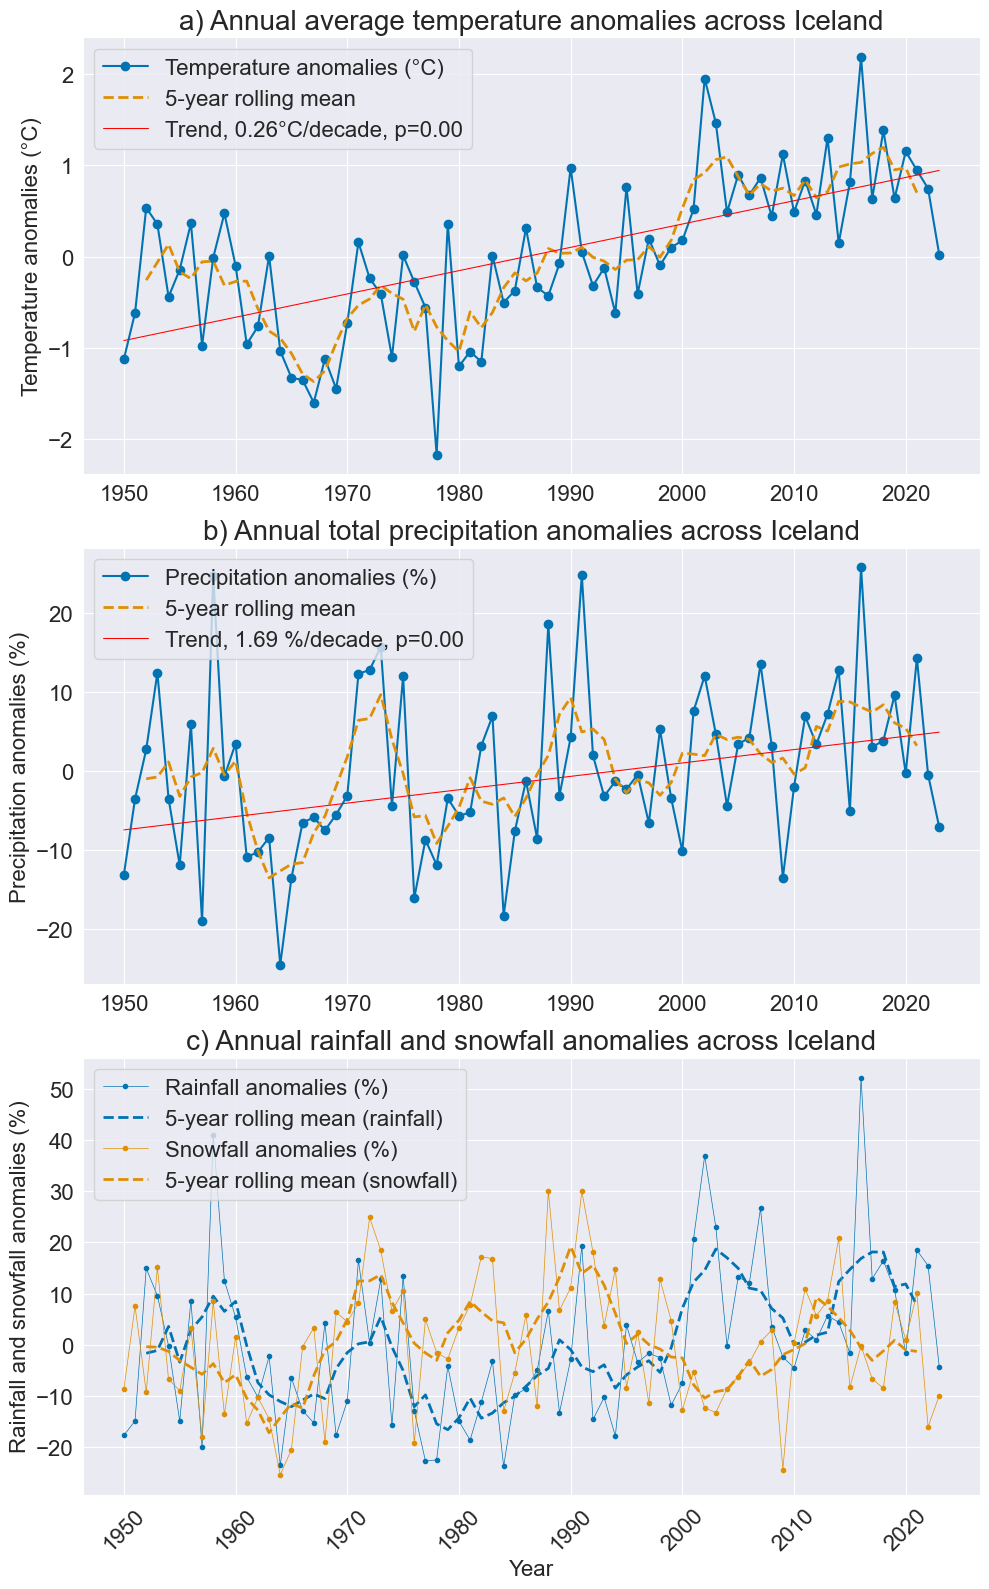

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import theilslopes
import pymannkendall as mk
from pathlib import Path
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette("colorblind") 
rcParams['font.family'] = 'Arial'

# Load the dataset that was computed from Google Earth Engine
df = pd.read_csv(Path(r"ERA5Land_WaterYear_Stats_Iceland.csv"))

# Clean and rename columns
df_clean = df[['water_year', 'temperature_2m', 'total_precipitation_sum', 'snowfall_sum']].copy()
df_clean.rename(columns={
    'temperature_2m': 'Temperature (K)',
    'total_precipitation_sum': 'Precipitation (m)',
    'snowfall_sum': 'Snowfall (m)'
}, inplace=True)

# Convert temperature from Kelvin to Celsius
df_clean['Temperature (°C)'] = df_clean['Temperature (K)'] - 273.15

# Compute rainfall
df_clean['Rainfall (m)'] = df_clean['Precipitation (m)'] - df_clean['Snowfall (m)']

# Set water_year as index
df_clean.set_index('water_year', inplace=True)

# --- Calculate deviations from the mean ---
mean_temp = df_clean['Temperature (°C)'].mean()
df_clean['Temperature Deviation (°C)'] = df_clean['Temperature (°C)'] - mean_temp

mean_precip = df_clean['Precipitation (m)'].mean()
mean_rainfall = df_clean['Rainfall (m)'].mean()
mean_snowfall = df_clean['Snowfall (m)'].mean()

df_clean['Precipitation Deviation (%)'] = (df_clean['Precipitation (m)'] - mean_precip) / mean_precip * 100
df_clean['Rainfall Deviation (%)'] = (df_clean['Rainfall (m)'] - mean_rainfall) / mean_rainfall * 100
df_clean['Snowfall Deviation (%)'] = (df_clean['Snowfall (m)'] - mean_snowfall) / mean_snowfall * 100

# --- Calculate 5-year rolling means ---
df_clean['5-Year Rolling Mean (Temp Deviation)'] = df_clean['Temperature Deviation (°C)'].rolling(window=5, center=True).mean()
df_clean['5-Year Rolling Mean (Precip Deviation)'] = df_clean['Precipitation Deviation (%)'].rolling(window=5, center=True).mean()
df_clean['5-Year Rolling Mean (Rainfall Deviation)'] = df_clean['Rainfall Deviation (%)'].rolling(window=5, center=True).mean()
df_clean['5-Year Rolling Mean (Snowfall Deviation)'] = df_clean['Snowfall Deviation (%)'].rolling(window=5, center=True).mean()

# --- Trend analysis ---
years = np.arange(len(df_clean))

# Theil-Sen slopes
slope_temp, intercept_temp, _, _ = theilslopes(df_clean['Temperature Deviation (°C)'].values, years)
slope_precip, intercept_precip, _, _ = theilslopes(df_clean['Precipitation Deviation (%)'].values, years)

# Mann-Kendall test
mk_result_temp = mk.original_test(df_clean['Temperature Deviation (°C)'].values, alpha=0.05)
mk_result_precip = mk.original_test(df_clean['Precipitation Deviation (%)'].values, alpha=0.05)

# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 16))

# Temperature plot
ax1.plot(df_clean.index, df_clean['Temperature Deviation (°C)'], label='Temperature anomalies (°C)', marker='o')
ax1.plot(df_clean.index, df_clean['5-Year Rolling Mean (Temp Deviation)'], label='5-year rolling mean', ls='--', lw=2)
ax1.plot(df_clean.index, intercept_temp + slope_temp * years, color='red', lw=0.75,
         label='Trend, %.2f°C/decade, p=%.2f' % (slope_temp * 10, mk_result_temp.p))
ax1.set_title('a) Annual average temperature anomalies across Iceland', fontsize=20)
ax1.set_ylabel('Temperature anomalies (°C)', fontsize=16)
ax1.legend(fontsize=16)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=16)

# Precipitation plot
ax2.plot(df_clean.index, df_clean['Precipitation Deviation (%)'], label='Precipitation anomalies (%)', marker='o')
ax2.plot(df_clean.index, df_clean['5-Year Rolling Mean (Precip Deviation)'], label='5-year rolling mean', ls='--', lw=2)
ax2.plot(df_clean.index, intercept_precip + slope_precip * years, color='red', lw=0.75,
         label='Trend, %.2f %%/decade, p=%.2f' % (slope_precip * 10, mk_result_precip.p))
ax2.set_title('b) Annual total precipitation anomalies across Iceland', fontsize=20)
ax2.set_ylabel('Precipitation anomalies (%)', fontsize=16)
ax2.legend(loc='upper left', fontsize=16)
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=16)

# Rainfall and snowfall plot
ax3.plot(df_clean.index, df_clean['Rainfall Deviation (%)'], label='Rainfall anomalies (%)', marker='o', color='C0', lw=0.5, markersize=3)
ax3.plot(df_clean.index, df_clean['5-Year Rolling Mean (Rainfall Deviation)'], label='5-year rolling mean (rainfall)', ls='--', lw=2, color='C0')
ax3.plot(df_clean.index, df_clean['Snowfall Deviation (%)'], label='Snowfall anomalies (%)', marker='o', color='C1', lw=0.5, markersize=3)
ax3.plot(df_clean.index, df_clean['5-Year Rolling Mean (Snowfall Deviation)'], label='5-year rolling mean (snowfall)', ls='--', lw=2, color='C1')
ax3.set_title('c) Annual rainfall and snowfall anomalies across Iceland', fontsize=20)
ax3.set_xlabel('Year', fontsize=16)
ax3.set_ylabel('Rainfall and snowfall anomalies (%)', fontsize=16)
ax3.legend(fontsize=16)
ax3.grid(True)
ax3.tick_params(axis='both', which='major', labelsize=16)

plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
plt.savefig(Path("Figure1_era5l_anomalies.png"), dpi=300)
plt.savefig(Path("Figure1_era5l_anomalies.pdf"), dpi=300)
plt.show()

# Calculate the trend between 2000 and 2024

In [4]:
# --- Subset data to water years 2000–2024 ---
subset = df_clean.loc[2000:2024].copy()

# Re-index years starting from 0 for trend calculation
subset_years = np.arange(len(subset))

# Theil-Sen slopes
slope_temp_sub, intercept_temp_sub, _, _ = theilslopes(subset['Temperature Deviation (°C)'].values, subset_years)
slope_precip_sub, intercept_precip_sub, _, _ = theilslopes(subset['Precipitation Deviation (%)'].values, subset_years)

# Mann-Kendall test
mk_result_temp_sub = mk.original_test(subset['Temperature Deviation (°C)'].values, alpha=0.05)
mk_result_precip_sub = mk.original_test(subset['Precipitation Deviation (%)'].values, alpha=0.05)

# Print trend results
print("2000–2024 Trends:")
print(f"Temperature trend: {slope_temp_sub * 10:.2f} °C/decade, p={mk_result_temp_sub.p:.3f}, trend={mk_result_temp_sub.trend}")
print(f"Precipitation trend: {slope_precip_sub * 10:.2f} %/decade, p={mk_result_precip_sub.p:.3f}, trend={mk_result_precip_sub.trend}")


2000–2024 Trends:
Temperature trend: 0.01 °C/decade, p=0.980, trend=no trend
Precipitation trend: -0.12 %/decade, p=0.980, trend=no trend
